# Groverのアルゴリズム(2020 Week1-B)

このLabでは量子アルゴリズムの一つであるGrover (グローバー) のアルゴリズムについて学びます。

量子コンピューターの数ある優位性の１つに、データベース検索を高速に行えることを聞いたことがあるかも知れません。Groverのアルゴリズムはこの能力を実証します。
Groverのアルゴリズムは、非構造化データの検索問題に対して二次のオーダーの高速化ができる（古典計算で$N$回の計算となる問題が、量子計算では約$\sqrt N$回になる）だけではなく、検索以外の様々の用途でアルゴリズムの実行時間を二次のオーダーで改善する一般的な技術・サブルーチンとして利用されているアルゴリズムです。これは振幅増幅技術と呼ばれています。

このLabではGroverのアルゴリズムをQiskitを利用して実装します。

## 量子計算を用いた検索の理論
### 非構造化データの検索
$N$個の大きなアイテムリストがあるとします。その中で、一つだけアタリ$w$があるとします。

![](./resources/2020-w1-b-unstructured_search.png)

アタリの箱を見つけるためには、古典計算では平均で $N/2$ 個、最悪の場合は $N$ 個の箱を探す必要があります。  
ところが、量子コンピューターでは Groverの振幅増幅技術を使って、およそ $\sqrt N$ ステップでマークされたアイテムを探し出すことができます。  
二次の高速化は、現実で大きなリスト内のマークされたアイテムを探す際には大きな時間の節約になります。  
さらに、このアルゴリズムはリスト自体の内部構造を利用しないので、一般化することが可能で、多くの古典問題に対して二次の速度向上をもたらしてくれます。

### オラクル （Oracle）
量子コンピューターに対して上記のようなリストをどのように渡せばいいでしょうか？エンコードによく用いられる手法として、ハズレの$x$には$f(x)=0$を返し、アタリ$w$に対しては$f(w)=1$を返すような関数$f$を定義する手法が挙げられます。この問題を量子コンピューターで扱うには、リストの要素（=アイテム）を重ね合わせの状態で表現したうえで、この関数に渡す必要があります。  
数学的には、この関数はオラクルと呼ばれるユニタリー行列として定義されます。

そのために、まず初めにアイテムをバイナリ表現 $x,w \in \{0,1\}^n$($N=2^n$)で考えます。このように考えることで、アイテムを量子コンピューター上の量子ビットの状態として表現することができます。  
その後、オラクル$U_w$を任意の標準基底$|x\rangle$に対して$U_w |x\rangle =(-1)^{f(x)}|x\rangle$となるように定義することで、先程の関数と同じような考え方が量子状態を表現した行列に対しても適用出来ていることが確認できます。

$x$がハズレアイテムの場合、オラクルは量子状態に対して何も操作しません。ところが、アタリの状態$|w\rangle$に対してオラクルを適用すると、$U_w |w\rangle = -|w\rangle$のように操作します。  
このユニタリー行列の操作は幾何学的には、$N=2^n$次元のベクトル空間においてマークされたアイテムを原点に対して反転する操作に対応していると考えることが出来ます。

![](./resources/2020-w1-b-oracle.png)

### 振幅増幅（Amplitude amplification）
話をGroverのアルゴリズムに移します。私たちはリストを調べる前にアタリがどこにあるのか知りません。従って、下記のような均一な重ね合わせの量子状態で表現されると考えます。
$$ |s\rangle = \frac{1}{\sqrt N}\sum_{x=0}^{N-1} |x\rangle $$

もしこの時点で標準基底 $|x\rangle $でこの重ね合わせ状態を測定した場合、$\frac{1}{N} = \frac{1}{2^{n}} $ の確率で、標準基底のうちの一つに収束します。想像の通り、アタリ$|w\rangle$を引く確率は$\frac{1}{2^{n}}$ です。従って、正しいアイテムを推測するには、平均$N=2^{n}$回試行する必要があります。

そこで振幅増幅と呼ばれる技術を導入しましょう。この技術により、量子コンピューターがアタリを見つける確率を大幅に高めることが出来ます。  
この処理ではマークされたアイテムの確率振幅を増幅し、その他のアイテムの確率振幅を小さくします。これを繰り返して十分にアタリの確率振幅が大きくなった最終状態を測定することで、ほぼ確実にアタリを取り出すことができるようになります。


#### Step 0:
振幅増幅は均一な重ね合わせ状態 $|s\rangle$ から開始します。均一な重ね合わせ状態は、$|s\rangle = H^{\otimes n}|0\rangle^{n}$ のようにアダマールゲートを使って簡単に作成できます。  
初期状態は $|\psi_{0}\rangle = |s\rangle$ です。

![](./resources/2020-w1-b-step0.png)

このアルゴリズムは、幾何学的に２次元平面での回転として解釈することができます。  
今回私たちが関心があるのは、アタリ$|w\rangle$ と均一な重ね合わせ状態$|s\rangle$ という２つの特別な状態のみです。この２つはベクトル空間 $\mathbb C^{N}$ において２次元の平面を張ります。アタリの状態$|w\rangle$ は、$N^{-1/2}$ の振幅で重ね合わせ状態に含まれるため、これら２つのベクトルは完全に直交しているわけではありません。  
しかし、$|s\rangle$ から $|w\rangle$ を削除し、正規化し直す事で $|w\rangle$ に直交する追加の状態 $|s'\rangle$ を作り出すことができます。左の図は、$|w\rangle, |s'\rangle$ によって張られる、２次元平面に対応しています。  

右の図は、$N=2^n$ の場合の、状態 $|\psi_{t}\rangle$ の振幅を表す棒グラフです。振幅の平均値は破線で示されています。

#### Step 1:
オラクル $U_{w}$ を状態に適用します $U_{w}|\psi_{t}\rangle = |\psi_{t'}\rangle$  
オラクルの状態操作は、幾何学的には状態 $|\psi_{t}\rangle$ を $|s'\rangle$ に対して反転させることに対応しています。この変換が意味することは、$|w\rangle$ 状態の振幅が負の値になるということで、結果として平均振幅が低くなることを意味しています。  
右側のグラフで破線が下がっていることに着目してください。

![](./resources/2020-w1-b-step1.png)

#### Step 2:
次に、$|s\rangle$ に対して $U_{s}$ を適用します：$U_{s} = 2|s\rangle \langle s| - 1 $ 。この変換の結果、状態は $U_{s}|\psi_{t'}\rangle$ となり、変換 $|\psi_{t+1}\rangle = U_{s}U_{w}|\psi_{t}\rangle$ が完了します。  
右側のグラフで$|w\rangle$に対応する振幅が増幅されていることに着目してください。

![](./resources/2020-w1-b-step2.png)

２つのStepにおける反転は2次元平面の回転と対応しています。$ U_{s}U_{w}$ による変換は、初期状態 $|s\rangle$ をアタリ　$|w\rangle$ に近づけるような回転となります（Step 2の左側の図を参照）。$U_{s}$ による反転の効果は、振幅の棒グラフにおいて、平均振幅での反転と解釈できます。最初の反転で平均振幅の値が低くなったので、この変換は、負の振幅をもった $|w\rangle$ をオリジナルの値から約３倍程度増幅し、他の振幅は小さくします。その後、Step1 に戻ってこれを繰り返します。アタリ $w$ に近くなるまで、この処理を何回か繰り返します。

この回転操作を $t$ 回繰り返した後、状態は $|\psi_{t}\rangle = (U_{s}U_{w})^{t}|\psi_{0}\rangle $ に変換されます。

では回転操作は何回適用する必要があるでしょうか？  
およそ $\sqrt N$ 回（解が$M$個ある場合 $\sqrt{(N/M)}$）で十分なことが分かっています。これは、状態 $|\psi_{t}\rangle$ の振幅を調べることで明確になります。$|w\rangle$ の振幅が適用回数と共に線型（$ \sim tN^{1/2}$）に増えていくことが見てとれます。
> 確率ではなく振幅を扱っているので、ベクトル空間の値には平方根として入ります。そのため、この処理で増幅されるのは、ただの確率ではなく振幅です。

![](./resources/2020-w1-b-grover_algorithm.png)

## Qiskitによる実装: 2量子ビットのGroverのアルゴリズム
では、GroverのアルゴリズムをQiskitで実装してみましょう。今回は、2量子ビットを使って、$|11\rangle$を見つけるGroverのアルゴリズムを実装します。

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [2]:
import qiskit
qiskit.__version__

'1.4.2'

上のStep1で実施したように求めたい解の符号を反転するオラクルを作成します。  
つまり今回は $U_{w} |11\rangle = -|11\rangle$

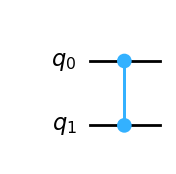

In [3]:
oracleCircuit = QuantumCircuit(2)
oracleCircuit.cz(0, 1)
oracleCircuit.draw("mpl")

次にStep 2で実施した平均についての反転(inversion about averate)をする回路を作成します。  
この回路はDiffusion回路と呼ばれることもあります。

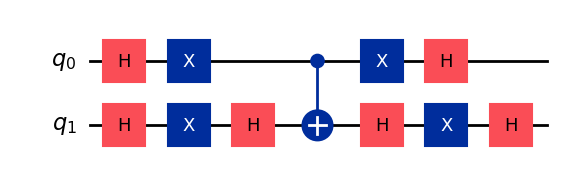

In [4]:
inversion_about_average = QuantumCircuit(2)

# Apply inversion about the average step of Grover's algorithm.
inversion_about_average.h(inversion_about_average.qubits)
inversion_about_average.x(inversion_about_average.qubits)
inversion_about_average.h(1)
inversion_about_average.cx(0, 1)
inversion_about_average.h(1)
inversion_about_average.x(inversion_about_average.qubits)
inversion_about_average.h(inversion_about_average.qubits)

inversion_about_average.draw(output='mpl')

回路の初めで均一な重ね合わせ状態を準備し、上記の部品を合わせて最後に測定を行います。  
2量子ビットなので4つの可能性のうちから1つの解を選ぶ問題と考えられるので、繰り返し回数は一回であることに注意してください。

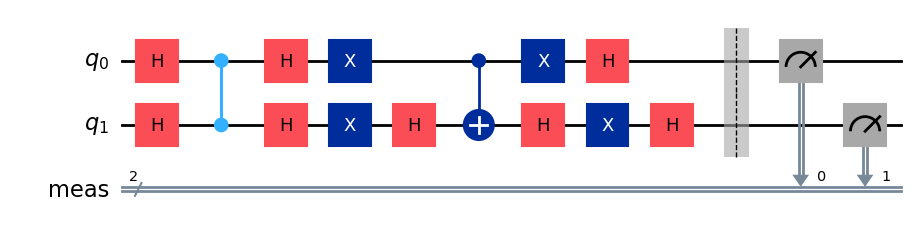

In [5]:
groverCircuit = QuantumCircuit(2)
groverCircuit.h(groverCircuit.qubits)

groverCircuit.compose(oracleCircuit, inplace=True)
groverCircuit.compose(inversion_about_average, inplace=True)

groverCircuit.measure_all()
groverCircuit.draw(output="mpl")

上記の回路をシミュレーターで実行してみます。

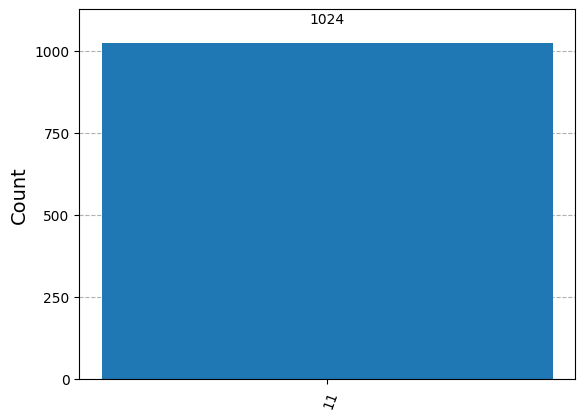

In [6]:
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram

sampler = StatevectorSampler()
result = sampler.run([groverCircuit]).result()
count = result[0].data.meas.get_counts()
plot_histogram(count)

実行結果から分かるようにGroverのアルゴリズムは解を発見しています。

## 補助量子ビットを用いた2量子ビットのGroverのアルゴリズム
同じ$|11\rangle$を見つける2量子ビットのGroverのアルゴリズムですが、補助量子ビットを用いることで、量子ビットの数が増えた際や問題が難しい際に複雑なオラクルを実装しやすくなります。

求めたい解（今回の場合、$|11\rangle$）の符号を反転するオラクルを作成します。ただし、今回は補助量子ビットを用いて$|11\rangle$の場合に符号が反転するようにします。この際、正しく符号を反転させるためには事前に補助ビットを$|1\rangle$にする必要があることに注意してください。

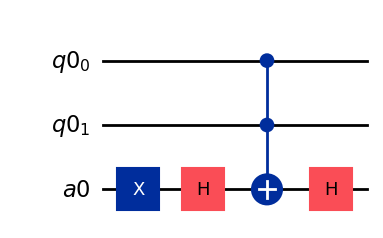

In [7]:
from qiskit.circuit import AncillaRegister

qr = QuantumRegister(2)
oracle_register = AncillaRegister(1)
oracleCircuit = QuantumCircuit(qr, oracle_register)

# initialize oracle_resgister |1>
oracleCircuit.x(oracle_register)

# oracle
oracleCircuit.h(oracle_register)
oracleCircuit.ccx(qr[0], qr[1], oracle_register)
oracleCircuit.h(oracle_register)

oracleCircuit.draw(output="mpl")

次に、Diffusion回路を準備します。Diffusion回路は補助ビットには作用しないようにしてください。

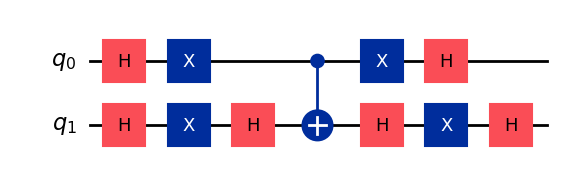

In [8]:
inversion_about_average = QuantumCircuit(2)

# Apply inversion about the average step of Grover's algorithm.
inversion_about_average.h(inversion_about_average.qubits)
inversion_about_average.x(inversion_about_average.qubits)
inversion_about_average.h(1)
inversion_about_average.cx(0, 1)
inversion_about_average.h(1)
inversion_about_average.x(inversion_about_average.qubits)
inversion_about_average.h(inversion_about_average.qubits)

inversion_about_average.draw(output='mpl')

補助ビットなしで作成した回路と同じように、回路の最初で均一な重ね合わせ状態を作成し（この際、補助ビットにHゲートをかけないように注意してください）、変換を適用し、最後に測定をします。

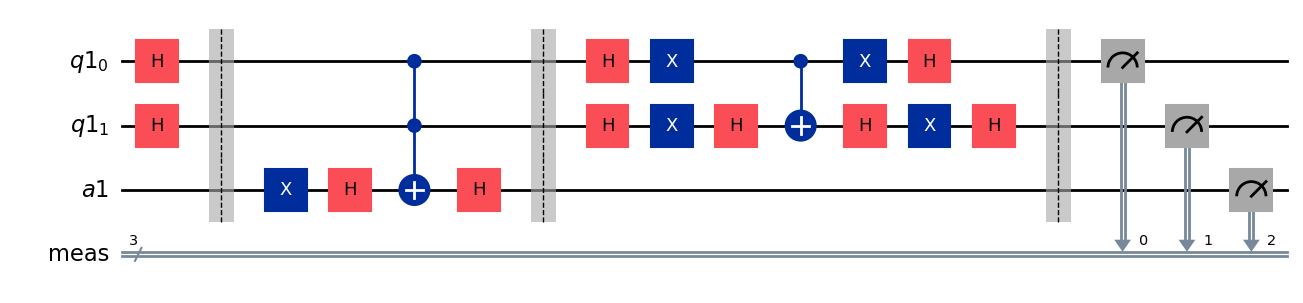

In [9]:
qr = QuantumRegister(2)
ancilla = AncillaRegister(1)

groverCircuit = QuantumCircuit(qr, ancilla)

# initialize qubits
groverCircuit.h(qr[0:2])
groverCircuit.barrier()

groverCircuit.compose(oracleCircuit, inplace=True)
groverCircuit.barrier()

groverCircuit.compose(inversion_about_average, [0, 1], inplace=True)

groverCircuit.measure_all()
groverCircuit.draw(output="mpl")

上記の回路をシミュレーターで実行してみます。

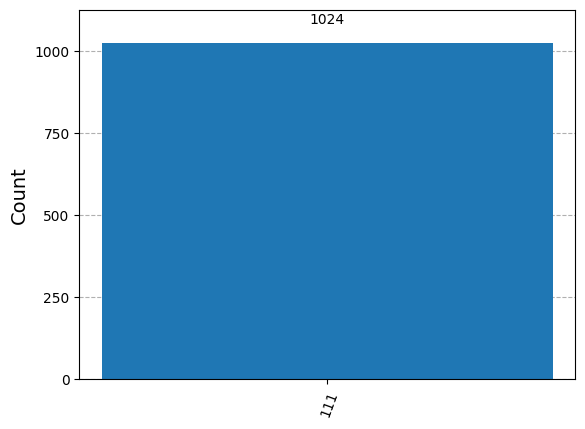

In [10]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()
result = sampler.run([groverCircuit]).result()
count = result[0].data.meas.get_counts()
plot_histogram(count)

補助ビットなしで作成した回路と同じように$|11\rangle$の状態の確率が増幅されていることが確認できます。最上位ビットの1は補助量子ビットのものなので無視して問題ありません。

## (参考) 繰り返しの回数
Groverのアルゴリズムは、解が完全に増幅されるまで約$\sqrt{N}$回繰り返しますと述べましたが、最も解が大きくなる繰り返し回数について考えてみましょう。

例えば、$N = 2^4$ のデータベースにGroverのアルゴリズムを実行させるとき、その回の測定確率は以下のように繰り返しの回数によって変化します。

In [11]:
prob_of_ans = []

for x in range(12):
    database = QuantumRegister(4)
    oracle = QuantumRegister(1)
    auxiliary = AncillaRegister(2) 
    cr = ClassicalRegister(4, 'meas')
    
    qc = QuantumCircuit(database, oracle, auxiliary, cr)
    qc.h(database[:])
    qc.x(oracle[0])
    qc.h(oracle[0])


    for j in range(x):
    # oracle_4q
        # search 7: 0111 
        qc.x(database[0])
        qc.mcx(database[:], oracle[0], auxiliary[:], mode='basic') 
        qc.x(database[0])

    # diffusion_4q
        qc.h(database[:])
        qc.x(database[:])
        qc.h(database[3])
        qc.mcx(database[0:3], database[3], auxiliary[:], mode='basic')
        qc.h(database[3])
        qc.x(database[:])
        qc.h(database[:])


    qc.h(oracle[0])
    qc.x(oracle[0])
    qc.measure(database, cr)
    # Change the endian 
    qc = qc.reverse_bits() 

    sampler = StatevectorSampler()
    result = sampler.run([qc]).result()
    count = result[0].data.meas.get_counts()
    answer = count['0111']
    prob_of_ans.append(answer)

Text(0, 0.5, '# of times the solution was obtained')

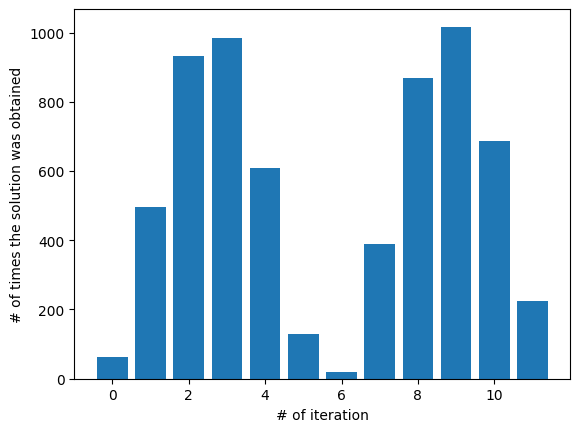

In [12]:
import numpy as np
import matplotlib.pyplot as plt
iteration = [i for i in range(12)]
correct = prob_of_ans
plt.bar(iteration, correct)
plt.xlabel('# of iteration')
plt.ylabel('# of times the solution was obtained')

## ハードウェアでの実験
今回構築したGroverの量子回路をハードウェア上で実行してみましょう。

In [13]:
# # Load our saved IBMQ accounts and get the least busy backend device
# # from qiskit import IBMQ, BasicAer
# # from qiskit.providers.ibmq import least_busy

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q')
# backend_lb = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
#                                    not b.configuration().simulator and b.status().operational==True))
# print("Least busy backend: ", backend_lb)

In [14]:
# # run our circuit on the least busy backend. Monitor the execution of the job in the queue
# from qiskit.tools.monitor import job_monitor

# backend = backend_lb
# shots = 1024
# job_exp = execute(groverCircuit, backend=backend, shots=shots)

# job_monitor(job_exp, interval = 2)

In [15]:
# # get the results from the computation
# results = job_exp.result()
# answer = results.get_counts(groverCircuit)
# plot_histogram(answer)